In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt

K = 3 # number of topics
V = 4 # size of vocabulary

# 13 documents with 5 words each
data = np.array([[0, 0, 0, 0, 0], 
                 [0, 0, 0, 0, 1], 
                 [0, 0, 0, 1, 1], 
                 [0, 0, 0, 0, 1], 
                 [0, 0, 0, 0, 1], 
                 [0, 0, 0, 0, 1], 
                 [0, 0, 0, 0, 0], 
                 [1, 1, 1, 2, 2], 
                 [1, 1, 1, 1, 2], 
                 [1, 1, 1, 2, 1], 
                 [1, 1, 1, 2, 2], 
                 [2, 2, 2, 3, 3], 
                 [2, 2, 2, 3, 3]])

# number of documents
D = data.shape[0]

# Hyper-parameters
alpha = np.ones(K)
beta = np.ones(V)

In [2]:
# flatten and index data
data_flatten = np.reshape(data, data.shape[0]*data.shape[1])
data_index = np.repeat(np.arange(data.shape[0]), data.shape[1])

with pm.Model() as model:
    # Global topic distribution
    theta = pm.Dirichlet("theta", a=alpha)
    
    # Word distributions for K topics
    phi = pm.Dirichlet("phi", a=beta, shape=(K, V))
    
    # Topic of documents
    z = pm.Categorical("z", p=theta, shape=D)
    
    # Words in documents
    p = phi[z][data_index]
    w = pm.Categorical("w", p=p, observed=data_flatten)
    trace = pm.sample(1000, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [phi, theta]
>CategoricalGibbsMetropolis: [z]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 366.12draws/s]
The acceptance probability does not match the target. It is 0.655923054639865, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7160642522268545, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


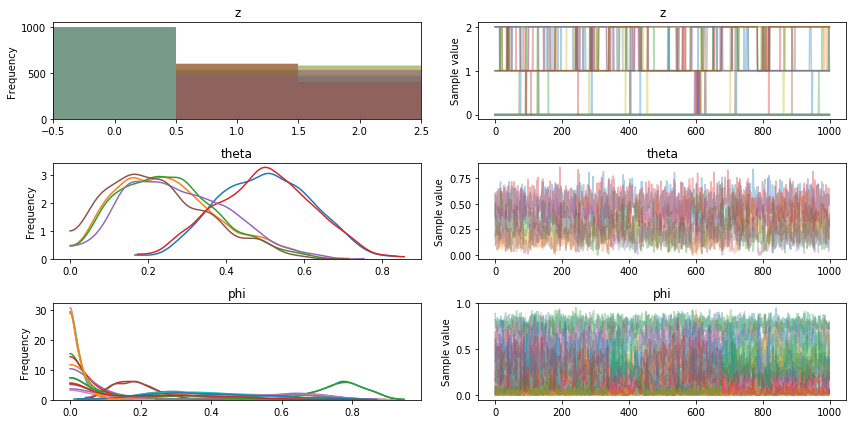

In [16]:
pm.traceplot(trace);

In [4]:
pm.summary(trace, varnames=['phi', 'theta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
phi__0_0,0.767031,0.069631,0.001593,6.277503e-01,0.892761,1987.943542,0.999504
phi__0_1,0.181087,0.062916,0.001489,7.232836e-02,0.309281,1952.204154,0.999529
phi__0_2,0.025629,0.025223,0.000531,2.203848e-05,0.075624,2237.573211,0.999517
phi__0_3,0.026253,0.026306,0.000542,6.223942e-07,0.076822,2147.930723,0.999638
phi__1_0,0.060979,0.089144,0.005605,6.115258e-05,0.176981,148.569805,1.005717
phi__1_1,0.391667,0.274725,0.025371,4.673757e-05,0.750244,18.785164,1.000189
phi__1_2,0.371475,0.153295,0.010356,1.064529e-01,0.679359,35.405424,1.001009
phi__1_3,0.175879,0.172184,0.014556,1.339372e-04,0.503669,22.741026,1.000775
phi__2_0,0.064814,0.073359,0.002845,9.266580e-05,0.215353,371.816660,1.004794
phi__2_1,0.318402,0.280335,0.025966,6.083247e-05,0.746069,17.018849,0.999529


In [17]:
with pm.Model() as model_marg:
    # Word distributions for K topics
    phi = pm.Dirichlet("phi", a=beta, shape=(K, V))
    
    # Topic of documents
    z = pm.Dirichlet("z", a=alpha, shape=(D, K))
    
    # Global topic distribution
    theta = pm.Deterministic("theta", z.mean(axis=0))
    
    # Words in documents
    comp_dists = pm.Categorical.dist(phi)
    w = pm.Mixture("w",
                   w=z[data_index, :],
                   comp_dists=comp_dists,
                   observed=data_flatten)
    trace_marg = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z, phi]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:14<00:00, 277.33draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
w.distribution.w.tag.test_value.shape

(65, 3)

In [12]:
w.distribution._comp_logp(data_flatten).tag.test_value.shape

(65, 3)

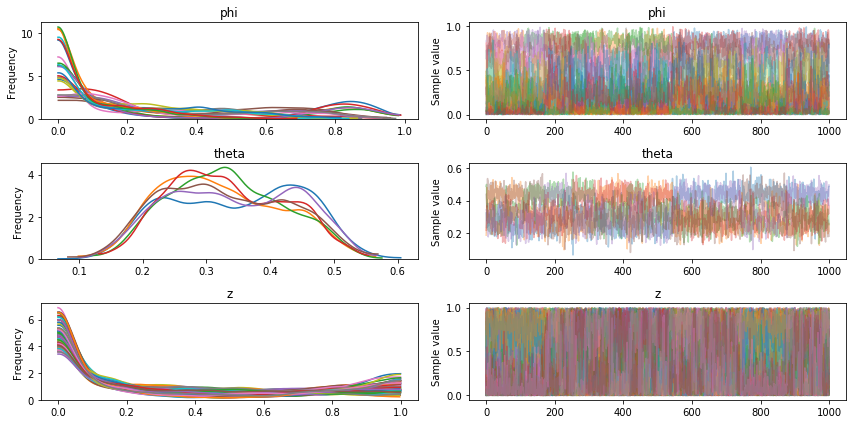

In [18]:
pm.traceplot(trace_marg, varnames=['phi', 'theta', 'z']);

In [19]:
pm.summary(trace_marg, varnames=['phi', 'theta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
phi__0_0,0.360845,0.366498,0.035084,0.000179,0.908646,7.489349,1.025980
phi__0_1,0.287387,0.256719,0.019291,0.000180,0.783759,21.590529,1.049721
phi__0_2,0.235631,0.215614,0.017585,0.000013,0.625880,13.558982,1.001734
phi__0_3,0.116138,0.129059,0.008826,0.000002,0.382549,28.866251,1.003110
phi__1_0,0.344932,0.356183,0.033043,0.000030,0.902707,24.569626,1.011260
phi__1_1,0.302150,0.259389,0.020091,0.000531,0.782870,88.618626,1.002247
phi__1_2,0.237536,0.213121,0.016880,0.000101,0.633028,38.486867,1.005596
phi__1_3,0.115381,0.124882,0.008724,0.000145,0.374724,76.291852,1.003941
phi__2_0,0.300131,0.342809,0.031981,0.000056,0.902333,16.217543,1.001070
phi__2_1,0.351522,0.272570,0.020761,0.000382,0.793941,53.191770,1.017621
